In [13]:
import pandas as pd
import numpy as np
from faker import Faker

# Initialize Faker for realistic data
fake = Faker()

# Generate mock claims data
np.random.seed(42)
n_entries = 10_000  # Simulate 10,000 claims

data = {
    "claim_id": [f"CLM_{i:05d}" for i in range(1, n_entries + 1)],
    "patient_id": [fake.uuid4() for _ in range(n_entries)],
    "provider_type": np.random.choice(
        ["Hospital", "Physician", "Nursing Facility", "Behavioral Health"], 
        size=n_entries,
        p=[0.4, 0.3, 0.2, 0.1]  # Weighted probabilities
    ),
    "service_date": [fake.date_between(start_date="-1y", end_date="today") for _ in range(n_entries)],
    "procedure_code": [fake.random_int(min=10000, max=99999) for _ in range(n_entries)],
    "cost": np.round(np.random.lognormal(mean=5, sigma=1, size=n_entries), 2),
    "denial_flag": np.random.choice([0, 1], size=n_entries, p=[0.85, 0.15]),  # 15% denial rate
    "state": np.random.choice(["CA", "TX", "NY", "FL"], size=n_entries)
}

claims_df = pd.DataFrame(data)
claims_df.to_csv("medicaid_claims_sample.csv", index=False)

In [14]:
import sqlite3

# Create SQLite database
conn = sqlite3.connect("medicaid_claims.db")
cursor = conn.cursor()

# Create table and import data
claims_df.to_sql("claims", conn, if_exists="replace", index=False)

# Example SQL query: Average cost by provider type
query = """
SELECT 
    provider_type,
    COUNT(*) AS total_claims,
    ROUND(AVG(cost), 2) AS avg_cost,
    ROUND(SUM(cost), 2) AS total_spend
FROM claims
GROUP BY provider_type
ORDER BY total_spend DESC;
"""

result = pd.read_sql(query, conn)
print(result)

       provider_type  total_claims  avg_cost  total_spend
0           Hospital          4058    252.71   1025498.19
1          Physician          3055    251.10    767100.04
2   Nursing Facility          1926    233.77    450250.47
3  Behavioral Health           961    239.12    229794.39


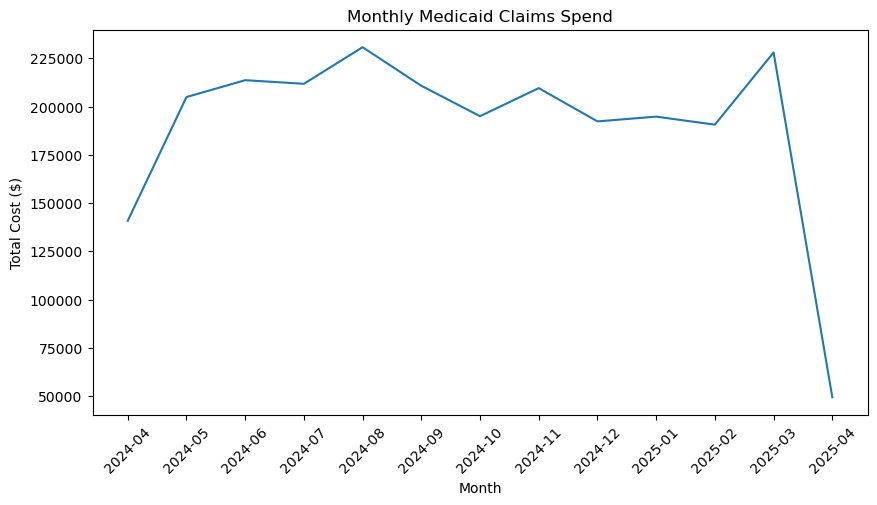

In [4]:
import matplotlib.pyplot as plt

# Monthly cost trends
claims_df["service_month"] = pd.to_datetime(claims_df["service_date"]).dt.to_period("M")
monthly_trends = claims_df.groupby("service_month")["cost"].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(monthly_trends["service_month"].astype(str), monthly_trends["cost"])
plt.title("Monthly Medicaid Claims Spend")
plt.xlabel("Month")
plt.ylabel("Total Cost ($)")
plt.xticks(rotation=45)
plt.show()

In [15]:
# Identify high-cost outliers (top 5%)
threshold = claims_df["cost"].quantile(0.95)
outliers = claims_df[claims_df["cost"] > threshold]

print(f"Outliers (> ${threshold:.2f}): {len(outliers)} claims")

Outliers (> $774.06): 500 claims


In [16]:
# Simulate reimbursement rates based on provider type and state
reimbursement_rates = {
    "Hospital": 0.75,  # 75% of cost
    "Physician": 0.85,
    "Nursing Facility": 0.65,
    "Behavioral Health": 0.90
}

claims_df["reimbursement"] = claims_df.apply(
    lambda row: row["cost"] * reimbursement_rates[row["provider_type"]], axis=1
)

# Total simulated reimbursement
total_reimbursement = claims_df["reimbursement"].sum()
print(f"Total Reimbursement: ${total_reimbursement:,.2f}")

Total Reimbursement: $1,920,636.43


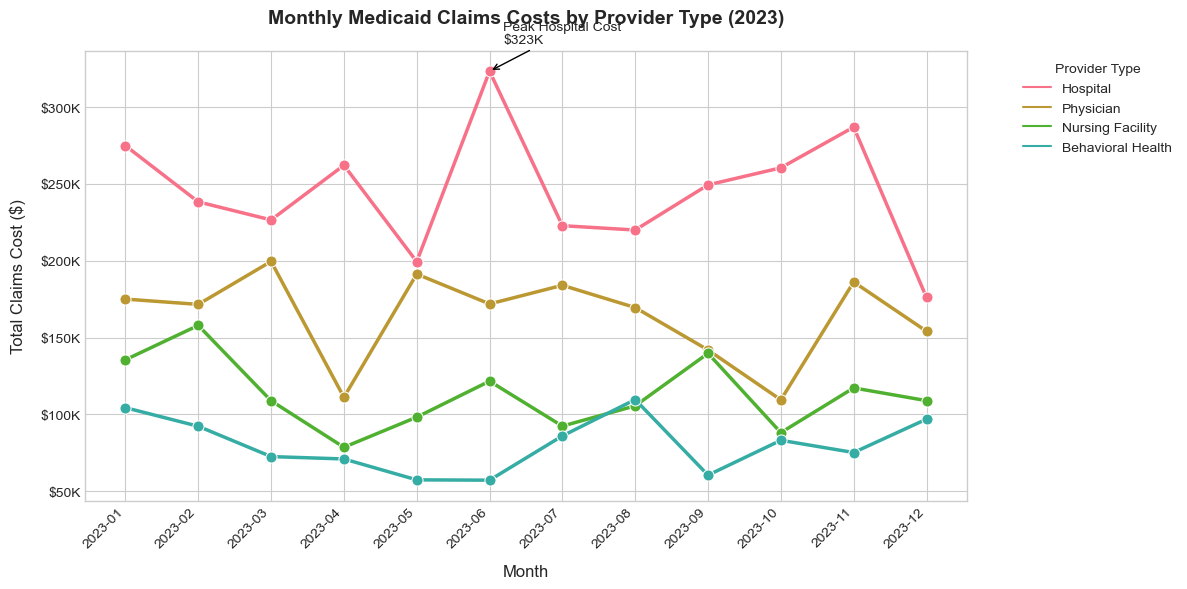

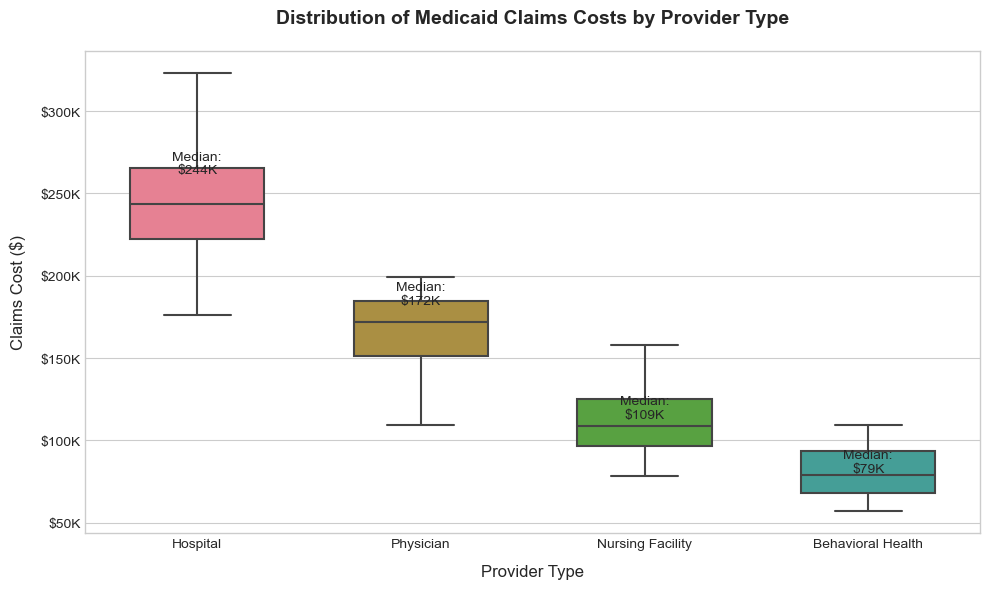

In [17]:
# -*- coding: utf-8 -*-
"""
Medicaid Claims Cost Trends Visualization
Courtney Lo | courtneylo08@yahoo.com
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set professional style
plt.style.use('seaborn-whitegrid')
sns.set_palette("husl")

# Sample data generation (replace with your actual data loading)
np.random.seed(42)
months = pd.date_range(start="2023-01", end="2024-01", freq='M')
provider_types = ['Hospital', 'Physician', 'Nursing Facility', 'Behavioral Health']

data = []
for month in months:
    for provider in provider_types:
        base_cost = {
            'Hospital': 250000,
            'Physician': 180000,
            'Nursing Facility': 120000,
            'Behavioral Health': 80000
        }[provider]
        
        data.append({
            'Month': month.strftime('%Y-%m'),
            'Provider': provider,
            'Cost': np.random.normal(base_cost, base_cost*0.2)
        })

df = pd.DataFrame(data)

# ---- Visualization 1: Monthly Trends by Provider ----
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df,
    x='Month',
    y='Cost',
    hue='Provider',
    marker='o',
    linewidth=2.5,
    markersize=8
)

# Formatting
ax.set_title('Monthly Medicaid Claims Costs by Provider Type (2023)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12, labelpad=10)
ax.set_ylabel('Total Claims Cost ($)', fontsize=12, labelpad=10)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1000:,.0f}K'))

# Annotations
max_hospital = df[df['Provider'] == 'Hospital'].loc[df['Cost'].idxmax()]
ax.annotate(f'Peak Hospital Cost\n${max_hospital["Cost"]/1000:,.0f}K', 
            xy=(max_hospital['Month'], max_hospital['Cost']),
            xytext=(10, 20), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

plt.xticks(rotation=45, ha='right')
plt.legend(title='Provider Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('medicaid_monthly_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# ---- Visualization 2: Cost Distribution ----
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='Provider',
    y='Cost',
    showfliers=False,
    width=0.6
)

# Formatting
plt.title('Distribution of Medicaid Claims Costs by Provider Type', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Provider Type', fontsize=12, labelpad=10)
plt.ylabel('Claims Cost ($)', fontsize=12, labelpad=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1000:,.0f}K'))

# Annotations
for i, provider in enumerate(provider_types):
    median = df[df['Provider'] == provider]['Cost'].median()
    plt.text(i, median*1.1, f'Median:\n${median/1000:,.0f}K', 
             ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('medicaid_cost_distribution.png', dpi=300)
plt.show()

In [18]:
# Load your CSV
df = pd.read_csv('medicaid_claims_sample.csv')  # Assuming file is in a 'data' folder

# Convert service_date to datetime and extract Year-Month
df['Month'] = pd.to_datetime(df['service_date']).dt.strftime('%Y-%m')

# Verify
print(df[['service_date', 'Month']].head())

  service_date    Month
0   2024-05-15  2024-05
1   2024-09-18  2024-09
2   2024-10-07  2024-10
3   2024-11-10  2024-11
4   2024-10-25  2024-10


In [21]:
# Export aggregated data for Tableau
summary_df = df.groupby(['Month', 'provider_type'], as_index=False).agg(
    Total_Cost=('cost', 'sum'),
    Claim_Count=('claim_id', 'count')  # Assuming your data has claim_id
)
summary_df.to_csv('medicaid_tableau_ready.csv', index=False)